## Model Regresion

Este notebook contiene el desarrollo de un modelo de aprendizaje automático resolviendo un problema de regresión. El objetivo es crear un modelo que permita tasar y avaluar propiedades inmobiliarias. El objetivo es predecir el valor de una vivienda.

Para esto se tiene en cuenta los siguientes pasos:
1. análisis exploratorio de datos
2. Detección y eliminación de Outliers
3. Encoding
4. Imputación de valores faltantes
5. Escalado de datos
6. Generación de nuevas variables predictoras/reduccin de dimensionalidad (SVD/PCA).
7.  Gnercion de modelos, tunning y resultados


In [42]:
# Librerias

# Tratamiento de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccion de Modelos
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Feature Enginerring
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder, LabelBinarizer

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion



In [4]:
# Lectura de informacion
df = pd.read_csv("data/Data.csv")
df.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [5]:
## descripcion de los datos
print("Tamano del dataset {}".format(df.shape))
print("----------------------------------")
print("Cantidad de datos faltantes \n{} ".format(df.isnull().sum()[df.isnull().sum()>0]))
print("----------------------------------")
print("Cantidad de duplicados \n{} ".format(df.shape[0]-df.drop_duplicates().shape[0]))


Tamano del dataset (146660, 19)
----------------------------------
Cantidad de datos faltantes 
lat                 9925
lon                 9959
bathrooms           5957
surface_total      20527
surface_covered    21614
dtype: int64 
----------------------------------
Cantidad de duplicados 
2358 


In [6]:
## descripcion de los datos
df.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,136735.000000,136701.000000,146660.000000,146660.000000,140703.000000,126133.000000,125046.000000,1.466600e+05
mean,-34.604896,-58.465304,3.079817,1.983240,1.599994,216.872888,112.818011,2.412211e+05
std,0.468428,0.486190,1.416352,1.151304,0.889324,2037.606649,916.857584,3.185195e+05
min,-35.318457,-180.000000,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,-34.627667,-58.504012,2.000000,1.000000,1.000000,52.000000,47.000000,1.110000e+05
50%,-34.600943,-58.443262,3.000000,2.000000,1.000000,78.000000,68.000000,1.660000e+05
75%,-34.574600,-58.407586,4.000000,3.000000,2.000000,140.000000,108.000000,2.650000e+05
max,85.051129,-57.805832,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


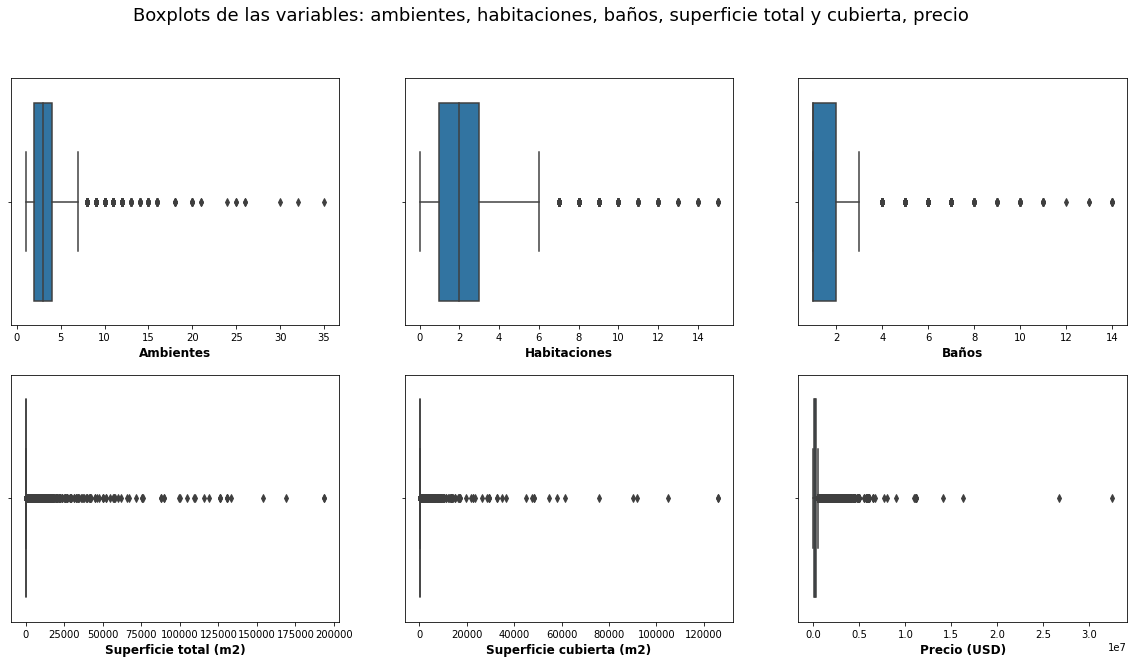

In [7]:
##Graficamos diagramas de caja para cada variable de interés y así poder tener una mejor idea de su distribución
plt.figure(figsize = (20,10))
plt.suptitle("Boxplots de las variables: ambientes, habitaciones, baños, superficie total y cubierta, precio", fontsize=18, color = "black")

plt.subplot(2,3,1)
sns.boxplot(x = df.rooms)
plt.xlabel("Ambientes", fontweight = "black", fontsize = 12)

plt.subplot(2,3,2)
sns.boxplot(x =df.bedrooms)
plt.xlabel("Habitaciones", fontweight = "black", fontsize = 12)

plt.subplot(2,3,3)
sns.boxplot(x =df.bathrooms)
plt.xlabel("Baños", fontweight = "black", fontsize = 12)

plt.subplot(2,3,4)
sns.boxplot(x =df.surface_total)
plt.xlabel("Superficie total (m2)", fontweight = "black", fontsize = 12)

plt.subplot(2,3,5)
sns.boxplot(x =df.surface_covered)
plt.xlabel("Superficie cubierta (m2)", fontweight = "black", fontsize = 12)

plt.subplot(2,3,6)
sns.boxplot(x =df.price)
plt.xlabel("Precio (USD)", fontweight = "black", fontsize = 12)

plt.show()

Tipos de propiedad y cantidad de instancias por cada una:
Departamento       107326
Casa                21521
PH                  14298
Lote                 1312
Oficina               658
Otro                  374
Local comercial       325
Casa de campo         322
Depósito              265
Cochera               259
Name: property_type, dtype: int64


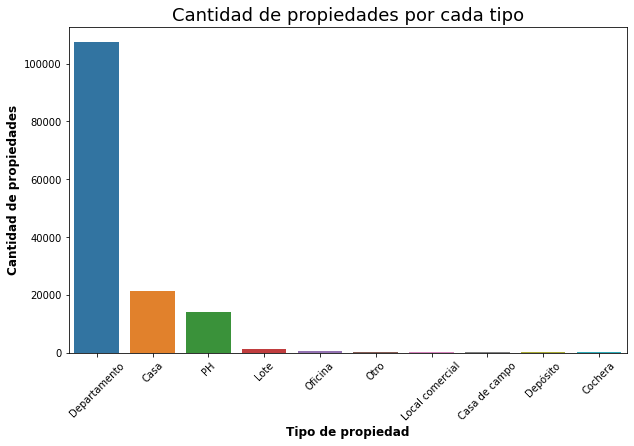

In [8]:
##Graficamos distribución de tipos de propiedad
print("Tipos de propiedad y cantidad de instancias por cada una:\n", df["property_type"].value_counts(), sep = "")

plt.figure(figsize = (10,6))
sns.countplot(x = "property_type", data = df, order = df['property_type'].value_counts().index)
plt.xticks(rotation = 45)
plt.xlabel("Tipo de propiedad", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad de propiedades", fontweight = "black", fontsize = 12)
plt.title("Cantidad de propiedades por cada tipo", fontsize=18, color="black")
plt.show()

Zonas de Bs. As. y cantidad de instancias por cada una:
Capital Federal             92539
Bs.As. G.B.A. Zona Norte    24282
Bs.As. G.B.A. Zona Sur      17173
Bs.As. G.B.A. Zona Oeste    12666
Name: l2, dtype: int64


Text(0.5, 1.0, 'Cantidad de propiedades por cada barrio')

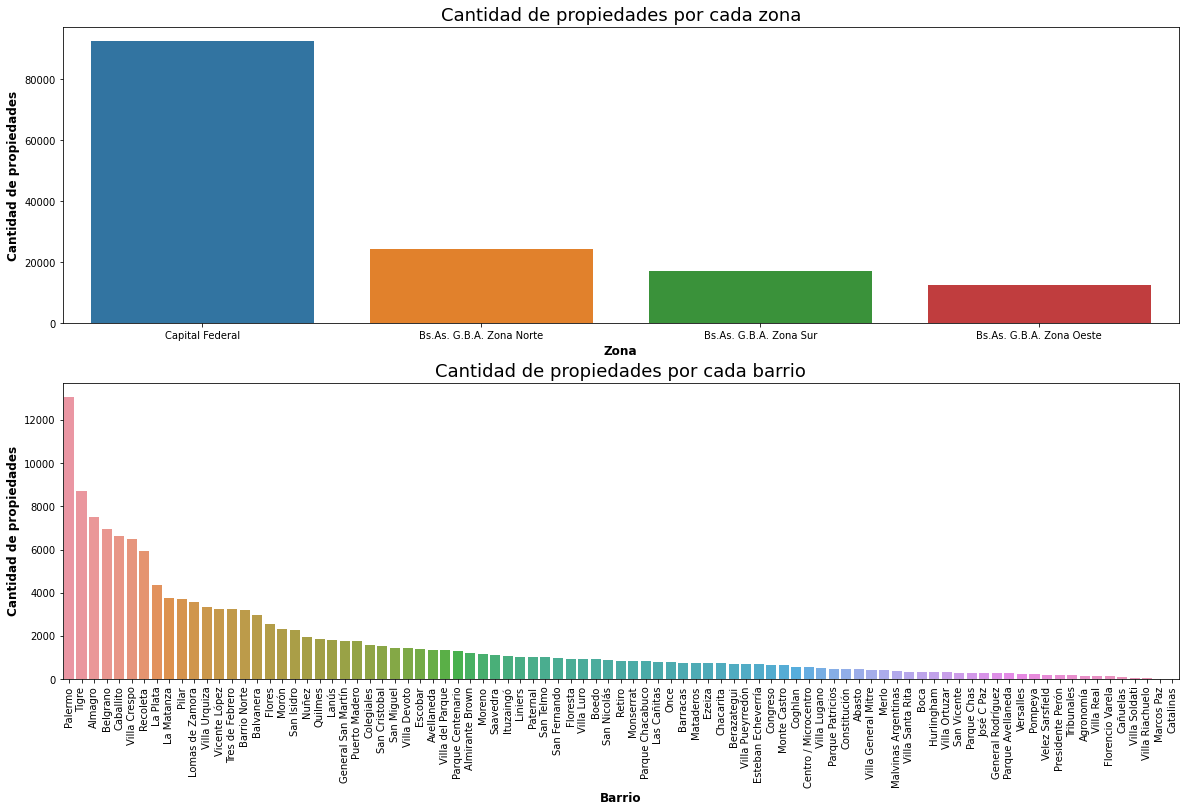

In [9]:
##Graficamos distribución por zona geografica de las propiedades
print("Zonas de Bs. As. y cantidad de instancias por cada una:\n", df["l2"].value_counts(), sep = "")

plt.figure(figsize = (20,12))

plt.subplot(2,1,1)
sns.countplot(x = "l2", data = df, order = df['l2'].value_counts().index)
plt.xlabel("Zona", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad de propiedades", fontweight = "black", fontsize = 12)
plt.title("Cantidad de propiedades por cada zona", fontsize=18, color="black")

plt.subplot(2,1,2)
sns.countplot(x = "l3", data = df, order = df['l3'].value_counts().index)
plt.xticks(rotation = 90)
plt.xlabel("Barrio", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad de propiedades", fontweight = "black", fontsize = 12)
plt.title("Cantidad de propiedades por cada barrio", fontsize=18, color="black")

**Dado el análisis exploratorio inicial se generan las siguientes consideraciones:**
* Existen 2358 registros duplicados
* Existen 5 variables que contienen datos vacíos
* Variables numéricas como Superficie total, superficie cubierta y precio tiene valores atípicos.
* La mayoria de inmuebles se son Casa, Departamento y PH. Estan ubicados su mayoria en Capital Federal

A continuación procedemos al tratamiento de estas consideraciones conn los siguientes metodos:

* Quitaremos duplicados
* Realizaremos un filtro para quedarnos con la informacion que consideramos relevante y consistente
* Removemos datos atipicos usando rango intercurtil
* Generaremos imputacion de datos mediante modelos de regresion lineal teniendo como covariable los barrios los cuales previamente fueron transformados y cuyas variables respuesta son lat, lon y bathrooms.


In [11]:
## remover duplicados -------------------------------
df.drop_duplicates(inplace=True)

## Limpieza  ----------------------------------------
datos_machine = df[(df.surface_total >= df.surface_covered)].copy()
datos_machine = datos_machine[(datos_machine.property_type.isin(['Casa','Departamento','PH']))&(datos_machine.l2=='Capital Federal')].copy()

## tratamiento de ouliers   -------------------------
data_seleccion = datos_machine[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price","property_type"]]
datos_machine = datos_machine[['lat', 'lon', 'l1', 'l2', 'l3']]
mínimo = data_seleccion.quantile (0.1) 
máximo = data_seleccion.quantile (0.9)
IQR = máximo - mínimo 
clean_select = data_seleccion[~ ((data_seleccion < (mínimo - 1.5 * IQR)) | (data_seleccion > (máximo + 1.5 * IQR))).any(axis=1)].copy()
df_ml = clean_select.merge(datos_machine,left_index=True, right_index=True,how = 'left')

### encoding    -----------------------------------
enc = LabelEncoder()
enc.fit(df_ml['l3'])
barrios_enc = enc.transform(df_ml['l3'])
df_ml.loc[:, 'l3'] = barrios_enc

### imputacion   -----------------------------------
def imputacion_regresion(datos,variablex,variabley):
    reg = LinearRegression()
    data_aux = datos[[variablex,variabley]].dropna()
    X = np.array(data_aux[variablex]).reshape(-1, 1)
    y = data_aux[variabley]
    reg.fit(X, y)
    X_test = np.array(datos[datos[variabley].isnull()][variablex]).reshape(-1, 1)
    lon_completar = reg.predict(X_test)
    datos.loc[datos[variabley].isnull(), variabley] = lon_completar
    return datos
df_ml = imputacion_regresion(datos=df_ml,variablex = "l3",variabley = "lon")
df_ml = imputacion_regresion(datos=df_ml,variablex = "l3",variabley = "lat")
df_ml = imputacion_regresion(datos=df_ml,variablex = "l3",variabley = "bathrooms")
df_ml = df_ml[['rooms','bedrooms','bathrooms','surface_total','surface_covered','price','lat','lon','l3','property_type']]


C:\Users\user\AppData\Local\Temp\ipykernel_14828\2555219489.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  clean_select = data_seleccion[~ ((data_seleccion < (mínimo - 1.5 * IQR)) | (data_seleccion > (máximo + 1.5 * IQR))).any(axis=1)].copy()


### Analisis de correlaciones

Procedemos a observar cuales son las variables que mas nos pueden aoprtar al modelo.

Text(0.5, 1.0, 'Correlacion')

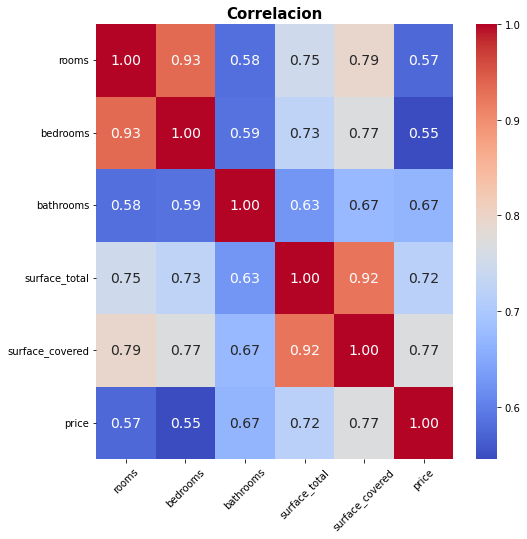

In [12]:
# Grafico de correlacion de spearman
correlation = clean_select.corr()
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar = True, annot=True, fmt= '.2f',annot_kws={'size': 14}, cmap= 'coolwarm')
plt.xticks(rotation = 45)
plt.title("Correlacion", fontweight = "black", fontsize = 15)


### División en conjuntos de entrenamiento y prueba 

Procedemos a partir los datos de entrada y nuestra variable objetivo en conjuntos de entrenamiento y prueba. En este caso lo haremos con 80% para entrenar y 20% para validar

In [13]:
#Variables de entrada y de respuesta   
y = df_ml["price"]
X = df_ml.drop(["price"], axis=1)

#Conjuntos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 42)

### Pipeline Feature Enginering

* Se crea un pipeline de sklearn para el procesamiento de variables, para esto inicialmente se crean tres clases. La primera permite usar un LabelBinarizer para convertir variables categoricas en onehotencoder, la segunda permite crear transformador y la tercera nos permitira seleccionar variables.


* Se crea pipeline para cada tipo de transformacion deacuerdo a los tipos de datos que se desea transformar
1. Pipeline para variables numericas
2. Pipeline para variables categoricas
3. pipeline para variables que no se desean transformar

In [15]:
# Clase onehotencoder -----------------------------------
class BinarizadorCategorico(LabelBinarizer):
    def fit(self, X, y=None):
        super(BinarizadorCategorico, self).fit(X)
        
    def transform(self, X, y=None):
        return super(BinarizadorCategorico, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(BinarizadorCategorico, self).fit(X).transform(X)

# Clase Transformador -----------------------------------

class TranformadorBase(TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        return self

# Clase Para extraer columnas -----------------------------------

class ColumnExtractor(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns  

    def transform(self,X, **transform_params):
        return np.array(X[self.columns])

    def fit(self,X,y=None, ** fit_params):
            return self

    

In [16]:
# Separacion de columnas por tido de dato -----------------------------------
cols_numerics = ['surface_total', 'surface_covered','lat','lon']
cols_categorical = ['property_type']
cols_not_transform = ['rooms','bedrooms','bathrooms','l3']

# Transformador por tido de dato ---------------------------------------------
escalador_numerico = StandardScaler()
escalador_one_hot = BinarizadorCategorico()

# Pipeline para transformar datos numericos -----------------------------------
pipeline_numeric = Pipeline([
    ['select_columns',ColumnExtractor(columns =cols_numerics)],
    ['scaler_nummeric',escalador_numerico]
])

# Pipeline para transformar datos categoricos -----------------------------------
pipeline_categorical = Pipeline([
    ['select_columns',ColumnExtractor(columns =cols_categorical)],
    ['scaler_nummeric',escalador_one_hot]
])

# Pipeline para datos originales ------------------------------------------------
pipeline_not_transform = Pipeline([
    ['select_columns',ColumnExtractor(columns =cols_not_transform)]
])

# Creacion de Pipeline unico conn los pipelines de transformacion -----------------
pipeline_procesador = FeatureUnion([
    ('variable_numeric', pipeline_numeric),
    ('variable_Categorical', pipeline_categorical),
    ('variable_not_transform', pipeline_not_transform),
])



## Pipeline Random Forest

In [34]:
#Estimador o algoritmo de aprendizaje ------------------------------------------
Estimador_Rf = RandomForestRegressor(n_jobs=-1)

#Pipeline de estimacion ------------------------------------------
pipeline_Rf = Pipeline([('pipeline_procesing', pipeline_procesador),
                        ('estimador', Estimador_Rf)])

#Grilla de hiperparametros ------------------------------------------
param_grid = {
    'estimador__n_estimators': [10,20,50,100],
    'estimador__max_depth':[2,3,5,7,12],
    'estimador__min_samples_leaf':[1,2,5]
}

#Búsqueda de hiperparámetros ------------------------------------------
search_rf = GridSearchCV(pipeline_Rf, param_grid, cv = 5,scoring='neg_mean_squared_error')
search_rf.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline_procesing',
                                        FeatureUnion(transformer_list=[('variable_numeric',
                                                                        Pipeline(steps=[('select_columns',
                                                                                         <__main__.ColumnExtractor object at 0x000001D5F3EA3220>),
                                                                                        ['scaler_nummeric',
                                                                                         StandardScaler()]])),
                                                                       ('variable_Categorical',
                                                                        Pipeline(steps=[('select_columns',
                                                                                         <__main__.ColumnExtractor object at 0x000001D5F3CE...
        

## Pipeline SGD

In [37]:
#Estimador o algoritmo de aprendizaje ------------------------------------------
Estimador_SGD = SGDRegressor()

#Pipeline de estimacion ------------------------------------------
pipeline_SGD = Pipeline([('pipeline_procesing', pipeline_procesador),
                        ('estimador', Estimador_SGD)])

#Grilla de hiperparametros ------------------------------------------
param_grid = {
   'estimador__alpha':[10**-1, 10**-2],
   'estimador__learning_rate':['constant'],
   'estimador__eta0':[0.1,0.01, 0.001]
}

#Búsqueda de hiperparámetros ------------------------------------------
search_sgd = GridSearchCV(pipeline_SGD, param_grid, cv = 5,scoring='neg_mean_squared_error')
search_sgd.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline_procesing',
                                        FeatureUnion(transformer_list=[('variable_numeric',
                                                                        Pipeline(steps=[('select_columns',
                                                                                         <__main__.ColumnExtractor object at 0x000001D5F3EA3220>),
                                                                                        ['scaler_nummeric',
                                                                                         StandardScaler()]])),
                                                                       ('variable_Categorical',
                                                                        Pipeline(steps=[('select_columns',
                                                                                         <__main__.ColumnExtractor object at 0x000001D5F3CE...,
       

## Pipeline kNN

In [41]:
#Estimador o algoritmo de aprendizaje ------------------------------------------
Estimador_knn = KNeighborsRegressor()

#Pipeline de estimacion ------------------------------------------
pipeline_Knn = Pipeline([('pipeline_procesing', pipeline_procesador),
                        ('estimador', Estimador_knn)])

#Grilla de hiperparametros ------------------------------------------
param_grid = {
   'estimador__n_neighbors':[3,4,5,6,7],
   'estimador__weights':['uniform', 'distance']
}

#Búsqueda de hiperparámetros ------------------------------------------
search_knn = GridSearchCV(pipeline_Knn, param_grid, cv = 5,scoring='neg_mean_squared_error')
search_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline_procesing',
                                        FeatureUnion(transformer_list=[('variable_numeric',
                                                                        Pipeline(steps=[('select_columns',
                                                                                         <__main__.ColumnExtractor object at 0x000001D5F3EA3220>),
                                                                                        ['scaler_nummeric',
                                                                                         StandardScaler()]])),
                                                                       ('variable_Categorical',
                                                                        Pipeline(steps=[('select_columns',
                                                                                         <__main__.ColumnExtractor object at 0x000001D5F3CEA5B0>),
    

## Pipeline xgboost

In [44]:
#Estimador o algoritmo de aprendizaje ------------------------------------------
Estimador_xgb = XGBRegressor()

#Pipeline de estimacion ------------------------------------------
pipeline_xgb = Pipeline([('pipeline_procesing', pipeline_procesador),
                        ('estimador', Estimador_xgb)])

#Grilla de hiperparametros ------------------------------------------
param_grid = {
   'estimador__max_depth':range(3,10,2),
   #'estimador__min_child_weight':range(1,6,2),
   #'estimador__reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
   #'estimador__learning_rate' :[0.01,0.1,0.5]
}

#Búsqueda de hiperparámetros ------------------------------------------
search_xgb = GridSearchCV(pipeline_xgb, param_grid, cv = 5,scoring='neg_mean_squared_error')
search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline_procesing',
                                        FeatureUnion(transformer_list=[('variable_numeric',
                                                                        Pipeline(steps=[('select_columns',
                                                                                         <__main__.ColumnExtractor object at 0x000001D5F3EA3220>),
                                                                                        ['scaler_nummeric',
                                                                                         StandardScaler()]])),
                                                                       ('variable_Categorical',
                                                                        Pipeline(steps=[('select_columns',
                                                                                         <__main__.ColumnExtractor object at 0x000001D5F3CE...
        

## Seleccion de Modelos

In [45]:
# Calculo de metricas y seleccion del mejor modelo (train-val dataset)
from sklearn.metrics import mean_squared_error
metric_train, metric_test = [], []
models = [search_rf, search_sgd, search_knn,search_xgb]
model_name = ['Random Forest','SGD','Knn','Xgboost']
for predictor in models:
    mse_train = mean_squared_error(predictor.predict(X_train), y_train)
    mse_test = mean_squared_error(predictor.predict(X_test), y_test)
    metric_train.append(mse_train)
    metric_test.append(mse_test)

Resultados = pd.DataFrame({'Model':model_name, 'Mse_Train':metric_train,'Mse_Test':metric_test})
Resultados

,Model,Mse_Train,Mse_Test
0,Random Forest,1.492953e+09,2.274169e+09
1,SGD,1.344424e+11,1.343835e+11
2,Knn,5.292249e+07,1.698913e+09
3,Xgboost,6.279332e+08,1.652763e+09
